In [1]:
import os
import random
import sys
import warnings
import re
warnings.filterwarnings('ignore')

## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

from IPython.display import Audio
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import itertools

import sklearn
import itertools

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
Ravdess = "/content/gdrive/MyDrive/archive/"


In [4]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotion,Path
0,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
1,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
2,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
3,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
4,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...


In [5]:

Ravdess_df.to_csv("data_path.csv",index=False)
Ravdess_df.shape

(1452, 2)

In [6]:
Ravdess_df.head(10)

,Emotion,Path
0,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
1,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
2,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
3,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
4,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
5,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
6,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
7,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
8,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
9,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...


# Data Visualisation and Exploration

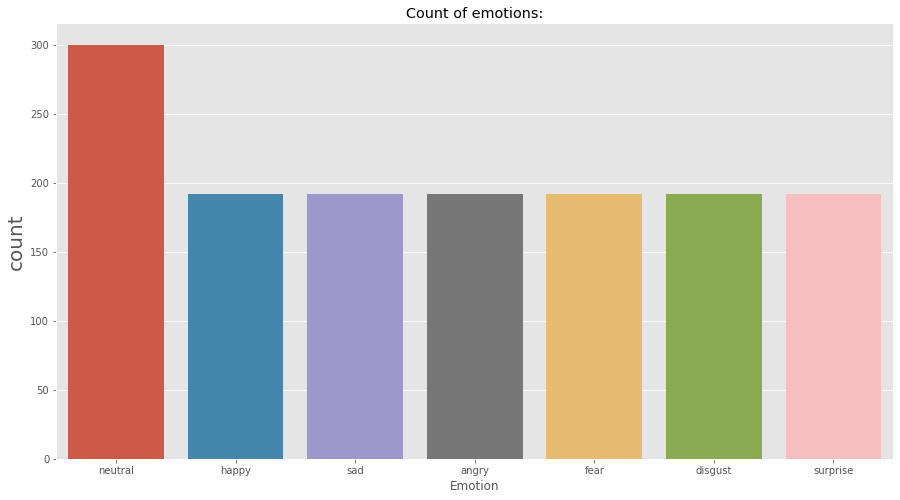

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,8)
plt.style.use("ggplot")
plt.ylabel('Count', size=20)
plt.title("Count of emotions:")
sns.countplot(x=Ravdess_df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

# We can also plot waveplots and spectograms for audio signals.

In [8]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

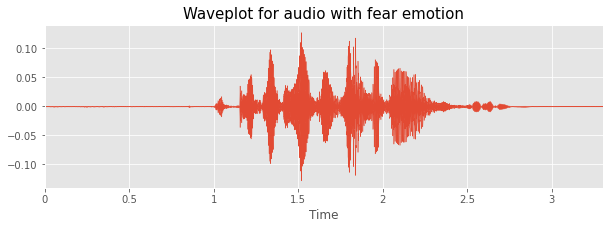

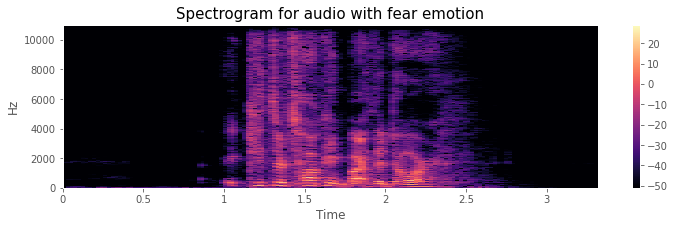

In [9]:
emotion='fear'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

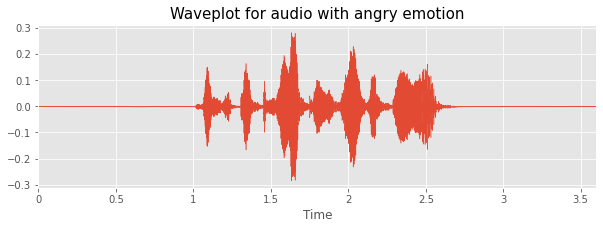

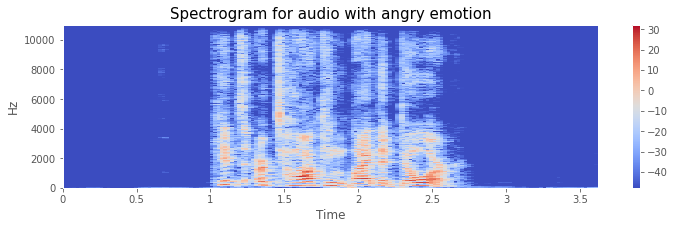

In [10]:
emotion='angry'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

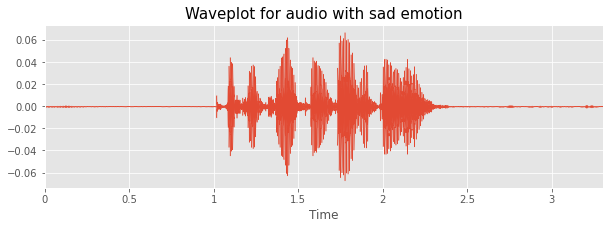

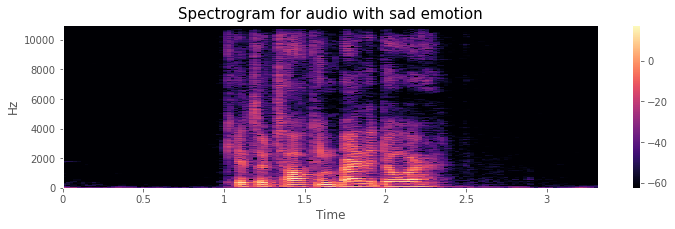

In [11]:
emotion='sad'
path = np.array(Ravdess_df.Path[Ravdess_df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

In [12]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [13]:
Ravdess_df.head()

,Emotion,Path
0,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
1,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
2,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
3,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...
4,neutral,/content/gdrive/MyDrive/archive/Actor_15/03-01...


In [14]:
path = Ravdess_df[Ravdess_df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

#### 1. Simple Audio

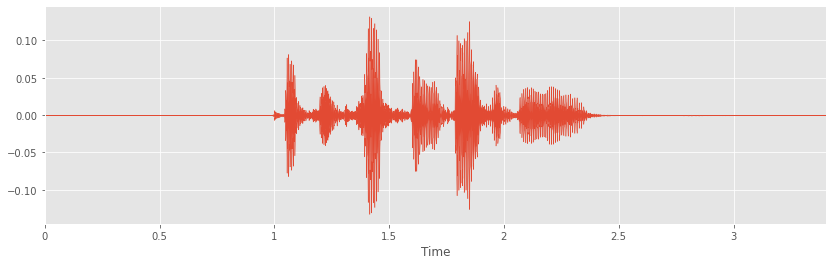

In [15]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
Audio(path)

#### 2. Noise Injection

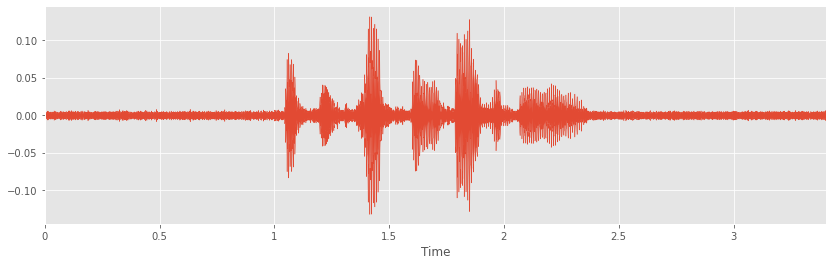

In [16]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)

#### 3. Stretching

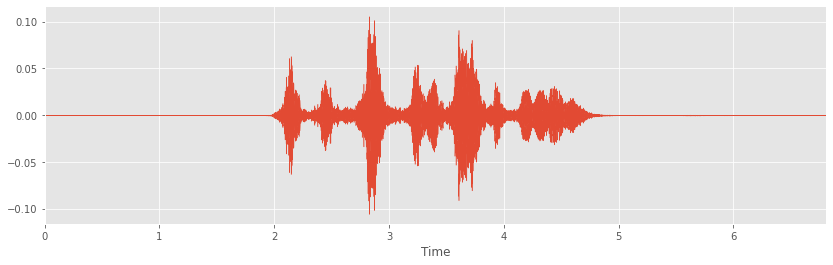

In [17]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)

#### 4. Shifting

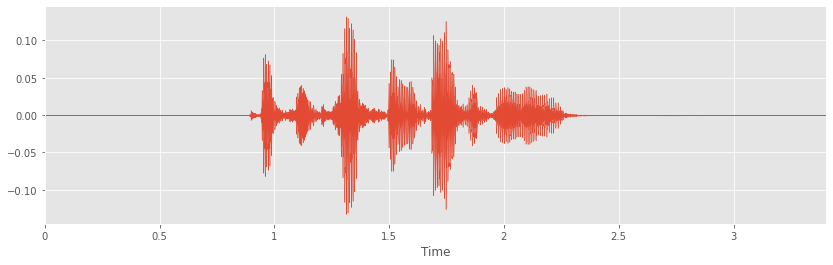

In [18]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)

#### 5. Pitch

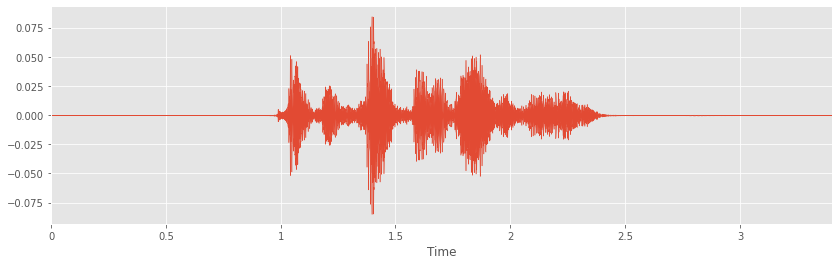

In [19]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

# Feature Extraction

In [20]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [21]:
path = np.array(Ravdess_df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

55125

In [22]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (108,)
Energy:  (108,)
Entropy of Energy : (108,)
RMS : (108,)
Spectral Centroid : (108,)
Spectral Flux:  ()
Spectral Rollof:  (108,)
Chroma STFT:  (1296,)
MelSpectrogram:  (13824,)
MFCC:  (2160,)


In [23]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        np.mean(energy(data, frame_length, hop_length),axis=0),
                        np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        spc(data, sr, frame_length, hop_length),
                        ##spc_entropy(data, sr),
                        ##spc_flux(data),
                        spc_rollof(data, sr, frame_length, hop_length),
                        chroma_stft(data, sr, frame_length, hop_length),
                        mel_spc(data, sr, frame_length, hop_length, flatten=True),
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [24]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [25]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(Ravdess_df.Path, Ravdess_df.Emotion, range(Ravdess_df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
Done.


In [26]:
features_path = "features.csv"

In [27]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17705,17706,17707,17708,17709,17710,17711,17712,17713,labels
0,0.257812,0.362305,0.437012,0.498047,0.447266,0.416504,0.460938,0.349121,0.251465,0.192383,...,11.087369,11.060812,10.250546,9.062897,8.257958,8.168784,8.352789,8.027040,6.849363,neutral
1,0.258301,0.373047,0.495605,0.486328,0.487305,0.499512,0.494629,0.494629,0.489258,0.479980,...,-4.246489,-1.314172,1.220912,0.947229,1.031380,2.453771,-0.105407,-1.274438,3.066873,neutral
2,0.128906,0.184082,0.229004,0.180664,0.167969,0.128906,0.103027,0.074707,0.046387,0.034180,...,9.896463,9.734882,9.406669,8.881046,8.182954,7.374041,6.530325,5.723793,5.012315,neutral
3,0.247070,0.368652,0.491211,0.488281,0.492188,0.488770,0.493652,0.506348,0.499512,0.492676,...,3.850440,4.459896,1.407173,2.220445,3.404398,-3.817887,-3.143691,2.290524,0.786159,neutral
4,0.286133,0.456055,0.655273,0.665039,0.666992,0.594238,0.404785,0.279785,0.235840,0.243164,...,6.863456,6.499415,6.221740,5.987135,5.752975,5.484034,5.157631,4.766580,4.319460,neutral


In [28]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(5808, 17715)


In [29]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
17710     False
17711     False
17712     False
17713     False
labels    False
Length: 17715, dtype: bool


(5808, 17715)

In [30]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17705,17706,17707,17708,17709,17710,17711,17712,17713,labels
0,0.257812,0.362305,0.437012,0.498047,0.447266,0.416504,0.460938,0.349121,0.251465,0.192383,...,11.087369,11.060812,10.250546,9.062897,8.257958,8.168784,8.352789,8.027040,6.849363,neutral
1,0.258301,0.373047,0.495605,0.486328,0.487305,0.499512,0.494629,0.494629,0.489258,0.479980,...,-4.246489,-1.314172,1.220912,0.947229,1.031380,2.453771,-0.105407,-1.274438,3.066873,neutral
2,0.128906,0.184082,0.229004,0.180664,0.167969,0.128906,0.103027,0.074707,0.046387,0.034180,...,9.896463,9.734882,9.406669,8.881046,8.182954,7.374041,6.530325,5.723793,5.012315,neutral
3,0.247070,0.368652,0.491211,0.488281,0.492188,0.488770,0.493652,0.506348,0.499512,0.492676,...,3.850440,4.459896,1.407173,2.220445,3.404398,-3.817887,-3.143691,2.290524,0.786159,neutral
4,0.286133,0.456055,0.655273,0.665039,0.666992,0.594238,0.404785,0.279785,0.235840,0.243164,...,6.863456,6.499415,6.221740,5.987135,5.752975,5.484034,5.157631,4.766580,4.319460,neutral


# Data Preparation

In [31]:
X = extracted_df.drop(labels="labels", axis=1)
y = extracted_df["labels"]

In [32]:
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4646, 17714), (1162, 17714), (4646, 7), (1162, 7))

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4181, 17714), (1162, 17714), (465, 17714), (4181, 7), (1162, 7), (465, 7))

In [35]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4181, 17714), (1162, 17714), (465, 17714), (4181, 7), (1162, 7), (465, 7))

In [36]:
#We have to use 1-dimensional CNN which need specifical shape:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(4181, 17714, 1)

### defining model

In [37]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [38]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [39]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [40]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17714, 512)        3072      
                                                                 
 batch_normalization (BatchN  (None, 17714, 512)       2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8857, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 8857, 512)         1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 8857, 512)        2048      
 hNormalization)                                                 
                                                        

In [42]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=30, batch_size=16,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/30
262/262 [==============================] - 192s 671ms/step - loss: 1.7449 - acc: 0.4221 - val_loss: 5.9812 - val_acc: 0.1441 - lr: 0.0010
Epoch 2/30
262/262 [==============================] - 181s 692ms/step - loss: 1.1857 - acc: 0.5788 - val_loss: 2.6452 - val_acc: 0.2753 - lr: 0.0010
Epoch 3/30
262/262 [==============================] - 183s 698ms/step - loss: 0.8846 - acc: 0.6915 - val_loss: 2.4075 - val_acc: 0.3505 - lr: 0.0010
Epoch 4/30
262/262 [==============================] - 185s 706ms/step - loss: 0.6004 - acc: 0.7847 - val_loss: 1.1596 - val_acc: 0.6667 - lr: 0.0010
Epoch 5/30
262/262 [==============================] - 184s 702ms/step - loss: 0.4760 - acc: 0.8271 - val_loss: 0.7519 - val_acc: 0.7656 - lr: 0.0010
Epoch 6/30
262/262 [==============================] - 188s 716ms/step - loss: 0.3171 - acc: 0.8873 - val_loss: 1.3205 - val_acc: 0.6495 - lr: 0.0010
Epoch 7/30
262/262 [==============================] - 186s 708ms/step - loss: 0.2620 - acc: 0.9108 - val_l

37/37 [==============================] - 16s 361ms/step - loss: 0.1848 - acc: 0.9466
Accuracy of our model on test data :  94.66437101364136 %


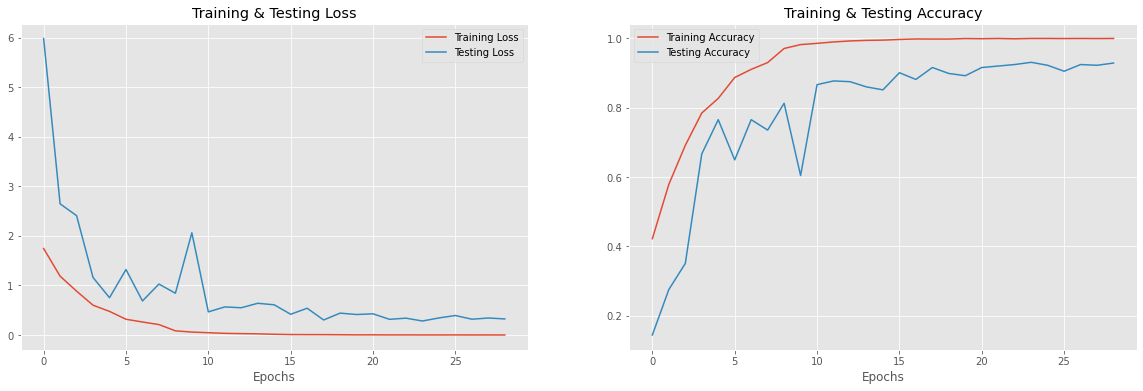

In [43]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [44]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([4, 6, 3, ..., 2, 0, 4])

In [45]:
y_check = np.argmax(y_test, axis=1)
y_check

array([4, 6, 3, ..., 2, 0, 4])

In [46]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [47]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[135   1   1   2   2   0   1]
 [  1 142   0   1   3   3   1]
 [  4   0 137   5   2   1   0]
 [  0   1   1 155   4   1   2]
 [  0   0   1   1 227   2   0]
 [  0   0   3   6   6 143   0]
 [  1   0   1   2   1   1 161]]


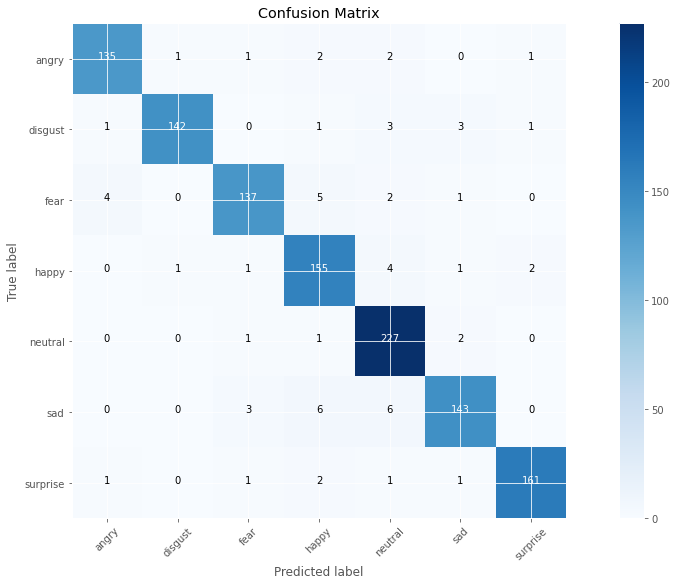

In [48]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# 